Automat zapisuje miejsce, w którym kończy się dany wzór.

In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from pprint import pprint

import random, string
from timeit import timeit
def print_arr(arr):
    for l in arr:
        for c in l:
            if c is None:
                print("{:^4}".format(-1), end="")
            else:
                print("{:^4}".format(c), end="")
        print()
    print()

class Automata:
    empty_str = "$"
    empty_any = -1
    class State:
        def __init__(self, fail_link=None):
            self.transitions = {}
            self.fail_link = fail_link
            self.accepting = False
            self.pattern_number = None
            self.id = 0

        def __repr__(self):
            res = "ID {} TRANSITIONS:\n".format(self.id)
            res += "{"

            for i, x in enumerate(self.transitions.items()):
                k, v = x
                res += "{}: {}".format(k, v.id)

                if i < len(self.transitions) - 1:
                    res+= ", "


            res += "}"

            res += "\nFAIL: {}\n".format(self.fail_link.id if self.fail_link else None)
            return res

        def __str__(self):
            return "{} {} {}".format(self.id, self.transitions, self.fail_link)

    def __init__(self, pattern_list, stop=False):
        self.start = self.State()
        # print("PATTERN")
        # print_arr(pattern_list)
        if type(pattern_list[0]) == list:
            pattern_list = [tuple(v) for v in pattern_list]
            # print("TO TUPLE")
            # print_arr(pattern_list)

        pattern_list_dict = {v : i for i, v in enumerate(pattern_list)}
        # print("PATTERN DICT")
        # pprint(pattern_list_dict)
        self.pattern = [[pattern_list_dict[v] for v in pattern_list]]

        id = 1

        for number, pattern in enumerate(pattern_list):
            state = self.start

            for letter in pattern:
                if letter not in state.transitions:
                    state.transitions[letter] = self.State(fail_link=self.start)
                    state.transitions[letter].id = id
                    id+=1
                state = state.transitions[letter]


            state.accepting=True
            state.pattern_number = number

        q = list(self.start.transitions.values())

        while q:
            state = q.pop(0)

            for letter, next_state in state.transitions.items():
                fail_link = state.fail_link

                while fail_link is not None:
                    if letter in fail_link.transitions:
                        next_state.fail_link = fail_link.transitions[letter]
                        break

                    fail_link = fail_link.fail_link

                q.append(next_state)

        if not stop:
            self.col_automata = Automata(self.pattern, stop = True)

    def run2d(self, text_2d, stop=False):
        max_len = max(len(l) for l in text_2d)
        matched = [None] * len(text_2d)

        # print_arr(text_2d)
        # for l in self.pattern:
        #     for c in l:
        #         if c is None:
        #             print("{:^4}".format(-1), end="")
        #         else:
        #             print("{:^4}".format(c), end="")
        #     print()
        for i, col in enumerate(text_2d):
            if len(col) < max_len:
                if type(col) == str:
                    col += self.empty_str*(max_len - len(col))
                elif type(col) == list:
                    col += [self.empty_any]*(max_len - len(col))
            m = self.run(col)

            matched[i] = m
        if not stop:
            # print_arr(matched)
            matched = self.col_automata.run2d(list(map(list, zip(*matched))), True)
            matches = []

            for i in range(len(matched)):
                for j in range(len(matched[i])):
                    if matched[i][j] in self.col_automata.pattern[0]:
                        matches.append((j, i))

            return matches

        return matched
    def run(self, text):
        # for c in text:
        #     print("{:^4}".format(c), end="")
        # print()
        state = self.start

        end_is_accepting = [-1] * len(text)

        for i, letter in enumerate(text):
            # print(letter, state)
            # print(letter)
            # print(state.__repr__())
            if letter in state.transitions:
                state = state.transitions[letter]
            else:
                # print("FAIL LINK")
                while state is not None:
                    # print("     {}".format(state.id))
                    if letter in state.transitions:
                        state = state.transitions[letter]
                        break
                    state = state.fail_link

            if state is None:
                state = self.start

            if state.accepting is True:
                # print("ACCEPTING")
                end_is_accepting[i] = state.pattern_number


        return end_is_accepting

    def visualize(self, figsize=(15,15)):
        plt.figure(figsize=figsize)
        G = nx.DiGraph()

        q = []
        q.append(self.start)
        while(q):
            node = q.pop()

            G.add_node(node.id, label=node.id)


            for label, child in node.transitions.items():
                G.add_edge(node.id, child.id, label = str(label))
                q.append(child)

        pos = graphviz_layout(G, prog='dot')

        q=[self.start]
        while(q):
            node = q.pop()
            G.add_edge(node.id, node.fail_link.id, label="F") if node.fail_link else None

            for label, child in node.transitions.items():
                q.append(child)


        labels_egdes = {(u, v) : l['label'] for u, v, l in G.edges(data = True)}
        labels_nodes = {u : l['label'] for u, l in G.nodes(data=True)}

        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_edges(G, pos, arrows=True) #, connectionstyle='arc3, rad = 0.1'
        nx.draw_networkx_edge_labels(G, pos, labels_egdes, font_size = 12, label_pos=0.3)
        nx.draw_networkx_labels(G, pos, labels_nodes)

        plt.show()

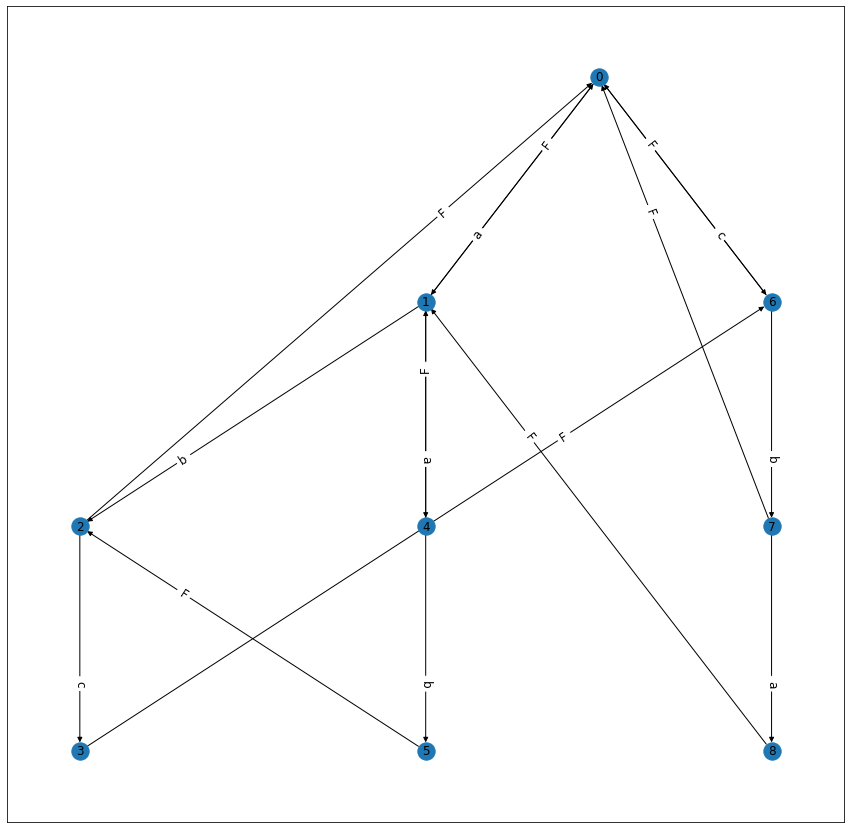

In [2]:
patterns = ["abc", "aab", "cba"]

automata = Automata(patterns)
automata.visualize()

In [3]:
automata.run("aaabca")

[-1, -1, -1, 1, 0, -1]

In [4]:
automata.run("baaabc")

[-1, -1, -1, -1, 1, 0]

In [5]:
automata.run("abaa")

[-1, -1, -1, -1]

In [6]:
automata.run("bca")

[-1, -1, -1]

In [7]:
test_text = ["abbbdsa",
             "cdab",
             "cdcddd"]
test_pattern = ["c", "c"]

automata2d = Automata(test_pattern)
automata2d.run2d(test_text)

[(2, 0)]

In [8]:
f = open('haystack.txt', 'r')
text = f.readlines()
# pprint(text)
letters=set()
for l in text:
    for c in l:
        letters.add(c)
print(f.read())
for letter in sorted(letters):
    automaton = Automata([letter, letter])
    res = automaton.run2d(text)
    print("'{:1}' --> {}".format(letter, len(res)))


'
' --> 1
' ' --> 158
'"' --> 0
'(' --> 0
')' --> 0
',' --> 0
'-' --> 0
'.' --> 0
'0' --> 0
'1' --> 0
'3' --> 0
'5' --> 0
'6' --> 0
'7' --> 0
':' --> 0
';' --> 0
'A' --> 0
'B' --> 0
'C' --> 0
'D' --> 0
'E' --> 0
'F' --> 0
'G' --> 0
'I' --> 0
'L' --> 0
'M' --> 0
'N' --> 0
'O' --> 0
'P' --> 0
'Q' --> 0
'R' --> 0
'S' --> 0
'T' --> 0
'U' --> 0
'V' --> 0
'W' --> 0
'X' --> 0
'a' --> 28
'b' --> 0
'c' --> 6
'd' --> 1
'e' --> 48
'f' --> 2
'g' --> 0
'h' --> 4
'i' --> 13
'j' --> 0
'k' --> 0
'l' --> 5
'm' --> 5
'n' --> 15
'o' --> 21
'p' --> 2
'q' --> 0
'r' --> 21
's' --> 19
't' --> 41
'u' --> 0
'v' --> 0
'w' --> 2
'x' --> 1
'y' --> 1
'z' --> 0


In [9]:
automaton = Automata(["th", "th"])
print("'th' found:", automaton.run2d(text))

automaton = Automata(["t h", "t h"])
print("'t h' found:", automaton.run2d(text))

'th' found: []
't h' found: [(38, 2)]


In [10]:
import cv2
import matplotlib.pyplot as plt

haystack_img = cv2.imread("haystack.png", cv2.IMREAD_GRAYSCALE)

haystack_img = cv2.threshold(haystack_img, 127, 255, cv2.THRESH_BINARY)[-1]

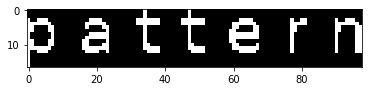

found in image 5
found in text  5


In [11]:
test_pattern_img = haystack_img[474:491,185:283]

plt.imshow(test_pattern_img, cmap='Greys')
plt.show()

pattern_automata_img = Automata(test_pattern_img.tolist())
pattern_automata_text = Automata(["p a t t e r n"])

print("found in image", len(pattern_automata_img.run2d(haystack_img)))
print("found in text ", len(pattern_automata_text.run2d(text)))


---
Checking letter w


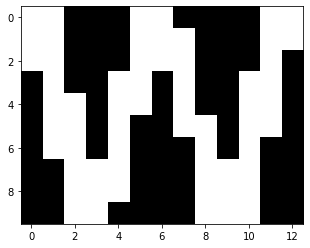

found in image 38
found in text  38
AUTOMATA BUILDING TIME
0.010334424001484876
n = 1 searching time
1.3171174790004443
n = 2 searching time
1.2968820539972512
n = 4 searching time
2.269211038001231
n = 8 searching time
4.724933269000758
---
Checking letter x


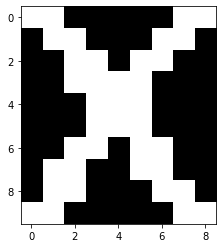

found in image 57
found in text  57
AUTOMATA BUILDING TIME
0.006284685001446633
n = 1 searching time
1.352753962000861
n = 2 searching time
1.3325507379995543
n = 4 searching time
2.313378807997651
n = 8 searching time
4.8022517030003655
---
Checking letter h


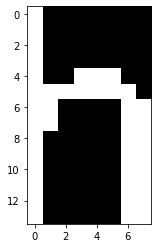

found in image 187
found in text  187
AUTOMATA BUILDING TIME
0.004978556997230044
n = 1 searching time
1.2534180510010628
n = 2 searching time
1.2222902409994276
n = 4 searching time
2.162457970000105
n = 8 searching time
4.518202747000032


In [12]:
letters_postions = {
    'w': ((59, 69), (49, 62)),
    'x': ((59, 69), (136, 145)),
    'h': ((143, 157), (110, 118)),
}

def time_this(n, automata):
    global haystack_img

    for i in range(n):
        f, t = int((i / n) * len(haystack_img)), int((i+1 / n) * len(haystack_img))

        automata.run2d(haystack_img[f:t].tolist())

for letter, ((y0, y1), (x0, x1)) in letters_postions.items():
    print("---")
    print("Checking letter {}".format(letter))
    letter_img = haystack_img[y0:y1, x0:x1]
    plt.imshow(letter_img, cmap='Greys')
    plt.show()

    automata_img = Automata(letter_img.tolist())
    print("found in image", len(automata_img.run2d(haystack_img.tolist())))
    automata_text = Automata([letter])
    print("found in text ", len(automata_text.run2d(text)))

    print("AUTOMATA BUILDING TIME")

    print(timeit(lambda : Automata(letter_img.tolist()), number=100))

    for i in range(4):
        n = 2 ** i

        print("n = {} searching time".format(n))
        print(timeit(lambda : time_this(n, automata_img), number=2))


In [14]:
def random_pattern(w, h):
    return [''.join(random.choices(string.ascii_uppercase + string.digits, k=w)) for _ in range(h)]


n = 30
build_times = [None] * n
run_times = [None] * n
xs = [None] * n
for i in range(1, n + 1):
    n = i * 2
    xs[i-1] = n
    pattern = random_pattern(n, n)

    automata = Automata(pattern)
    
    build = lambda : Automata(pattern)
    run = lambda : automata.run(pattern)

    build_time = timeit(build, number=100)
    run_time = timeit(run, number=100)

    build_times[i-1], run_times[i-1] = build_time, run_time

    # print("n = {}".format(i))
    # print("{}".format(build_time))
    # print("{}".format(run_time))
    #
    # print("")


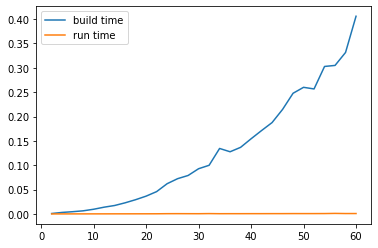

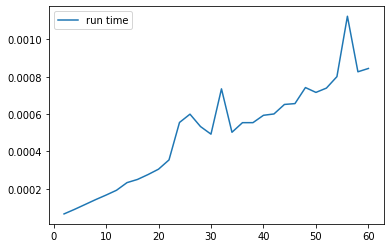

In [15]:
plt.plot(xs, build_times, label="build time")
plt.plot(xs, run_times, label="run time")
plt.legend()
plt.show()

plt.plot(xs, run_times, label="run time")
plt.legend()
plt.show()

